# Studying and Testing

## Comparing QIS and Empirical estimator

In [1]:
import numpy as np
import scipy.stats as st
import torch

In [2]:
rng = np.random.default_rng(0)
N = 100
batch_size = 300
A = rng.standard_normal((N,N))
Sigma_true1 = A @ A.T + 1e-6 *np.eye(N)

In [3]:
Sigma_true1

array([[ 93.22717079,   4.68888622,  -2.57613854, ...,   1.60080531,
         -5.1087686 ,  -1.17612947],
       [  4.68888622,  91.59238735,   3.95863851, ...,   2.26786021,
         -8.19998471,  17.42663099],
       [ -2.57613854,   3.95863851, 126.35231975, ...,  -7.22560372,
          2.06645757,  10.77842026],
       ...,
       [  1.60080531,   2.26786021,  -7.22560372, ...,  82.73596158,
        -15.32819255,  -2.68096208],
       [ -5.1087686 ,  -8.19998471,   2.06645757, ..., -15.32819255,
        115.81739059,   2.86096166],
       [ -1.17612947,  17.42663099,  10.77842026, ...,  -2.68096208,
          2.86096166,  65.31673004]], shape=(100, 100))

In [4]:
df = np.random.randint(
    int(1.5 * (N + 2)), 3 * N
)  # degrees of freedom for invwishart
df = 200*(N + 2)
df

20400

In [5]:
Sigma_true = st.invwishart.rvs(df=df, scale=np.eye(N))* (df - N - 1)
Sigma_true

array([[ 1.00613553e+00,  8.62238822e-03, -6.28376589e-03, ...,
        -6.84044302e-03, -6.35175654e-03, -1.03255600e-02],
       [ 8.62238822e-03,  9.98029116e-01, -7.46557303e-03, ...,
         9.15249093e-03, -6.70585613e-03,  2.18025020e-03],
       [-6.28376589e-03, -7.46557303e-03,  9.87896641e-01, ...,
         2.19749793e-03,  4.36721576e-04,  7.57665974e-03],
       ...,
       [-6.84044302e-03,  9.15249093e-03,  2.19749793e-03, ...,
         9.92220203e-01, -1.58967708e-04,  1.52384590e-02],
       [-6.35175654e-03, -6.70585613e-03,  4.36721576e-04, ...,
        -1.58967708e-04,  9.89994792e-01, -1.59958320e-02],
       [-1.03255600e-02,  2.18025020e-03,  7.57665974e-03, ...,
         1.52384590e-02, -1.59958320e-02,  9.97562712e-01]],
      shape=(100, 100))

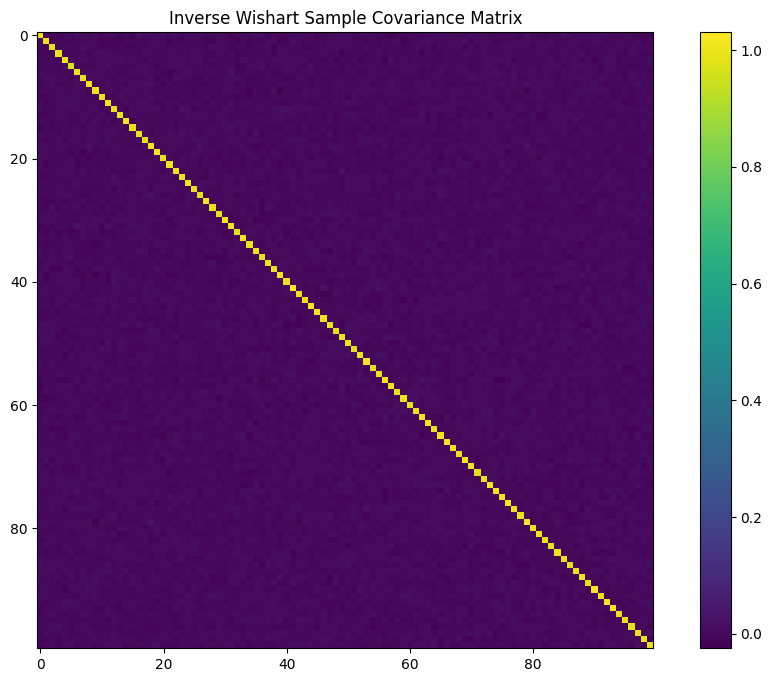

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.imshow(Sigma_true, cmap='viridis')
plt.colorbar()
plt.title('Inverse Wishart Sample Covariance Matrix')
plt.show()

In [7]:
rng = np.random.default_rng(0)

def computeFroEmp(Ts):
    frobs = np.zeros_like(Ts, dtype=float)
    for i, T in enumerate(Ts):
        R = rng.multivariate_normal(mean = np.zeros(shape=(N)), cov = Sigma_true, size=(1000, T)).transpose(0,2,1)
        R_centered = R - R.mean(axis=2, keepdims=True)
        Sigma_sample = R_centered @ R_centered.transpose(0,2,1)/(R.shape[-1]-1)
        frob = np.linalg.norm(Sigma_true[None,:,:] - Sigma_sample, axis=(1,2)).mean()
        frobs[i]=frob
    return frobs

In [8]:
Ts = [10, 50, 100, 500, 1000]
frobs = computeFroEmp(Ts)

In [9]:
frobs

array([33.50015664, 14.33598392, 10.08940544,  4.49282993,  3.17926367])

array([6.71345148, 2.94127175, 2.05643876, 0.90936557, 0.64688036,
       0.29196472, 0.20374291, 0.09137402, 0.06529839])

In [10]:
import matplotlib.pyplot as plt

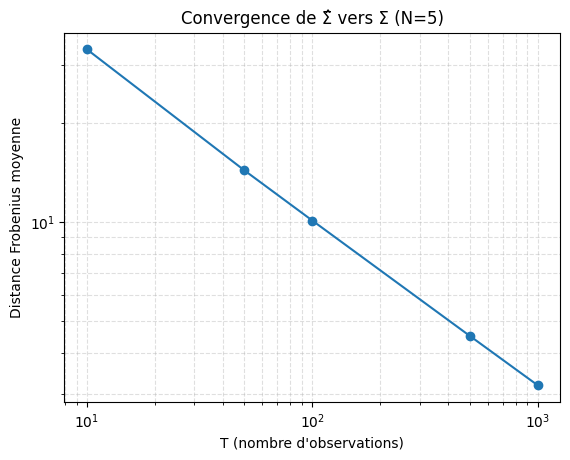

In [11]:
plt.figure()
plt.loglog(Ts, frobs, marker='o')
plt.xlabel("T (nombre d'observations)")
plt.ylabel("Distance Frobenius moyenne")
plt.title("Convergence de Σ̂ vers Σ (N=5)")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


the bigger T the smaller to frobenus distance is between the true matrix and the estimated one

In [12]:
from estimator.QIS import QIS_batched_numpy

In [13]:
T = 1000

In [14]:
def computeFroQIS(Ts):
    frobs = np.zeros_like(Ts, dtype=float)
    R = rng.multivariate_normal(mean = np.zeros(shape=(N)), cov = Sigma_true, size=(batch_size, T)).transpose(0,2,1)
    for i,t in enumerate(Ts):
        Sigma_QIS = QIS_batched_numpy(R[:,:,-t:])
        frob = np.linalg.norm(Sigma_true[None,:,:] - Sigma_QIS, axis=(1,2)).mean()
        frobs[i] = frob
    return frobs

In [15]:
def computeFroEmp(Ts):
    frobs = np.zeros_like(Ts, dtype=float)
    R = rng.multivariate_normal(mean = np.zeros(shape=(N)), cov = Sigma_true, size=(batch_size, T)).transpose(0,2,1)
    for i,t in enumerate(Ts):
        R_centered = R[:,:,-t:] - R[:,:,-t:].mean(axis=2, keepdims=True)
        Sigma_sample = R_centered @ R_centered.transpose(0,2,1)/(R[:,:,-t:].shape[-1]-1)
        frob = np.linalg.norm(Sigma_true[None,:,:] - Sigma_sample, axis=(1,2)).mean()
        frobs[i] = frob
    return frobs

In [16]:
Ts = np.concatenate([np.int64(np.linspace(0, T, 100))[:0:-1], [9,8,7,6,5,4,3,2]])
frobsQIS = computeFroQIS(Ts)

In [21]:
Ts = np.concatenate([np.int64(np.linspace(0, T, 100))[:0:-1], [9,8,7,6,5,4,3,2]])
frobsEMP = computeFroEmp(Ts)

NameError: name 'computeFroEmp' is not defined

NameError: name 'frobsQIS' is not defined

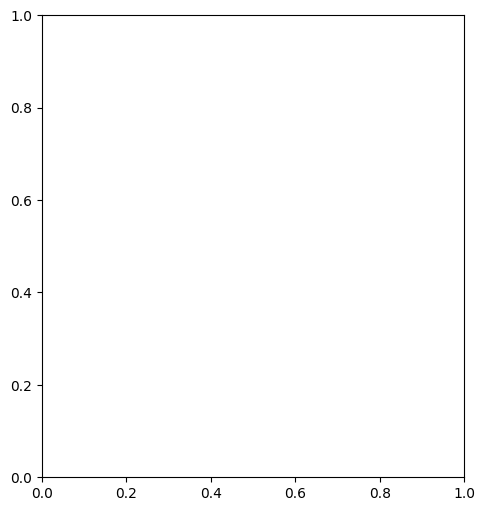

In [22]:
plt.figure(figsize=(12,6))

# Subplot 1 : en fonction de T
plt.subplot(1,2,1)
plt.plot(Ts, np.log10(frobsQIS), marker='o', label='QIS')
plt.plot(Ts, np.log10(frobsEMP), marker='x', label='EMP')
plt.xscale('log')
plt.xlabel("T (number of observations)")
plt.ylabel("log10 Frobenius distance")
plt.title("QIS vs Empirical (N=500)")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()

# Subplot 2 : en fonction du ratio q = N/T
plt.subplot(1,2,2)
plt.plot(N/Ts, np.log10(frobsQIS), marker='o', label='QIS')
plt.plot(N/Ts, np.log10(frobsEMP), marker='x', label='EMP')
plt.xscale('log')
plt.xlabel("N / T")
plt.ylabel("log10 Frobenius distance")
plt.title("Dependence on concentration ratio")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
np.log(np.linalg.norm(Sigma_true - np.eye(N,N)))

np.float64(-0.3662224319813351)

choosing df not too high overwise it will be too close to identity

## Study of wishart distribution

In [2]:
df = np.random.uniform(2 * (5 + 1), 10 * 5)
Sigma_true = torch.distributions.Wishart(
    df=df, covariance_matrix=torch.eye(5)
).sample((2,))*(df - 5 - 1)

Z = torch.randn(2, 10, 5)
L = torch.linalg.cholesky(Sigma_true)
R = L @ Z.transpose(1, 2)  # (B, N, T)

/Users/Utilisateur1/finance/covariance-cleaning/.venv/lib/python3.11/site-packages/torch/distributions/wishart.py:279: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [3]:
from data.dataloader import make_random_pattern_vecto
from data.dataloader import torch_cov_pairwise

In [4]:
R_hat, _, mask = make_random_pattern_vecto(R, 2)  # (B, N, T), (B, N), (B, N, T)

In [5]:
mask = R_hat.isnan()
true_indice = torch.where(mask)
R_hat

tensor([[[-12.0403,  22.3906,  18.8737,  11.0660, -11.9056, -16.2705,   3.0838,
            8.2741,  20.7724,  -8.7428],
         [     nan,      nan,      nan,   4.6593,  -4.1033, -16.0168,   9.5888,
          -19.0990,  -6.1468,  -7.1166],
         [     nan,      nan,      nan,  -2.3740,  16.1422,   3.9669,  -0.9735,
            5.4071,  -8.6273,  18.2477],
         [     nan,      nan,      nan,      nan,  25.0528,  -6.0375,  17.1168,
            8.4963, -33.3157,  -2.0570],
         [     nan,      nan,      nan,      nan,      nan, -13.7632, -12.2810,
          -16.3073,  -9.4367,  15.5215]],

        [[-17.6161,  -7.3751, -19.3975,  23.6065,  -9.7356,  -3.1375,   0.1005,
           -3.3290, -23.5971,  -1.3130],
         [  1.6394,  -4.0877, -18.4788,   1.1865,  -3.3838,  -4.2313,  -6.6534,
            0.0582,  13.5053,   4.1427],
         [     nan,      nan,      nan,  -1.9242,   2.5406,   7.2356,  26.3450,
            0.6705,  -1.0157, -10.2231],
         [     nan,      nan, 

In [6]:
true_indice

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]),
 tensor([1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 3, 3, 3, 3, 4, 4,
         4, 4]),
 tensor([0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 0, 1, 2, 3, 0, 1,
         2, 3]))

In [7]:
Sigma_hat = torch_cov_pairwise(
    R_hat
)

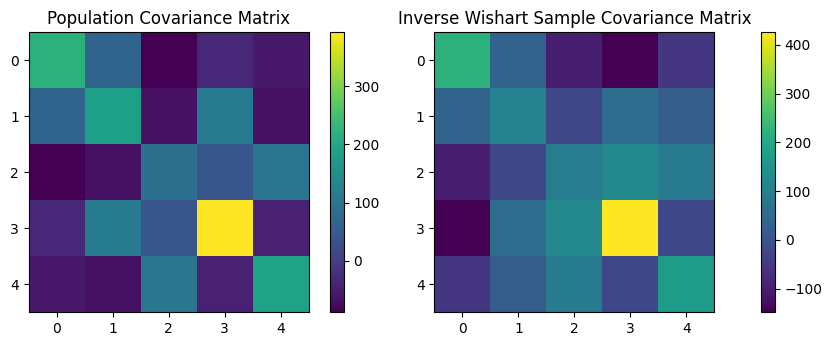

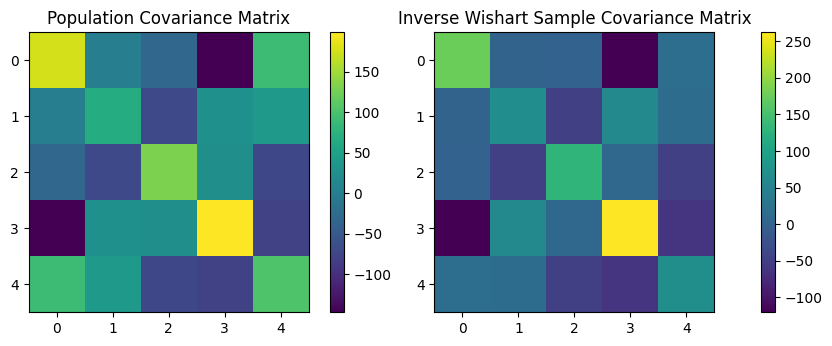

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.imshow(Sigma_hat[0], cmap='viridis')
plt.colorbar()
plt.title('Inverse Wishart Sample Covariance Matrix')
plt.subplot(2,2,1)
plt.imshow(np.cov(R[0]), cmap='viridis')
plt.colorbar()
plt.title('Population Covariance Matrix')
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.imshow(Sigma_hat[1], cmap='viridis')
plt.colorbar()
plt.title('Inverse Wishart Sample Covariance Matrix')
plt.subplot(2,2,1)
plt.imshow(np.cov(R[1]), cmap='viridis')
plt.colorbar()
plt.title('Population Covariance Matrix')
plt.show()

In [9]:
eigvals, eigvecs = torch.linalg.eigh(Sigma_hat)

In [10]:
eigvals_desc = torch.flip(eigvals, dims=[1])  # (B, N)
eigvecs_desc = torch.flip(eigvecs, dims=[2])  # (B, N, N)
eigvecs_desc

tensor([[[-4.6599e-01, -4.1401e-01,  4.3812e-01, -6.4729e-01,  2.2629e-02],
         [ 5.1497e-02, -2.2290e-01,  6.9768e-01,  5.6454e-01, -3.7709e-01],
         [ 3.3002e-01,  3.4443e-01,  4.5969e-02, -4.5304e-01, -7.5173e-01],
         [ 8.1362e-01, -4.4348e-01,  1.2271e-01, -2.0897e-01,  2.8743e-01],
         [ 9.6510e-02,  6.8088e-01,  5.5147e-01, -1.1571e-01,  4.5780e-01]],

        [[ 5.3007e-01, -1.5576e-04,  8.0365e-01,  5.1924e-02,  2.6548e-01],
         [-1.4425e-01,  4.3417e-01,  3.5755e-01, -3.8086e-01, -7.1958e-01],
         [-3.8789e-02, -8.1359e-01,  1.0652e-01, -5.5353e-01, -1.3722e-01],
         [-8.1098e-01,  5.4829e-02,  3.9911e-01, -5.1362e-02,  4.2116e-01],
         [ 1.9753e-01,  3.8283e-01, -2.3596e-01, -7.3704e-01,  4.6425e-01]]])

In [11]:
Tmin = mask.float().argmax(dim=2).unsqueeze(-1)  # (B, N, 1)
Tmax = mask.flip(dims=[2]).float().argmax(dim=2).unsqueeze(-1)  # (B, N, 1)

In [12]:
Tmin.transpose(1,2)

tensor([[[0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0]]])

In [13]:
Tmax.transpose(1,2)

tensor([[[0, 7, 7, 6, 5]],

        [[0, 0, 7, 6, 6]]])

In [14]:
eigvecs_desc.transpose(1, 2).pow(2) @ Tmin.float()

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.]]])

[166 171 127 187 199]
20.661817585910946


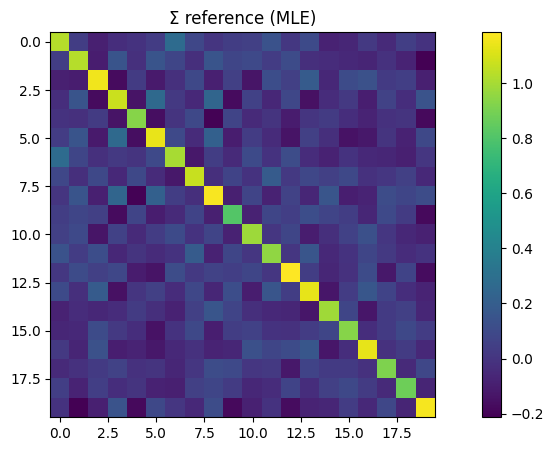

In [15]:
import scipy.stats as st
import matplotlib.pyplot as plt
N = 20
T = 40 # lots of noices if small
df = np.random.randint( 5* (N -1), 10 * N, size=5)  # degrees of freedom for invwishart

mat = st.invwishart.rvs(df=(df[0]), scale=np.eye(N))*(df[0]-N-1)
print(df)
print(np.trace(mat))
plt.figure(figsize=(12,5))
plt.imshow(mat, cmap='viridis')
plt.colorbar(); plt.title('Σ reference (MLE)')
plt.show()

In [16]:
df

array([166, 171, 127, 187, 199])

In [17]:
invwishart_sampler = np.vectorize(lambda x: st.invwishart.rvs(df=x, scale=np.eye(N))*(x-N-1), signature='()->(n,n)')
Sigma_true = invwishart_sampler(df)
Sigma_true = torch.tensor(Sigma_true, dtype=torch.float32)

In [18]:
#Sigma_true = torch.eye(N)
#Sigma_true = Sigma_true.expand(5, N, N).clone()

In [19]:
L = torch.linalg.cholesky(Sigma_true)
Z = torch.randn(5, T, N).transpose(1, 2)
R = L @ Z

In [23]:
# no missing data
Rc = R - R.mean(dim=1, keepdim=True)
cov = Rc @ Rc.transpose(1,2) / (T - 1)
cov.size()

torch.Size([5, 20, 20])

In [24]:
((Sigma_true - cov) ** 2).mean(dim=(1,2)) 

tensor([0.0296, 0.0260, 0.0332, 0.0252, 0.0236])

tensor([0.0100, 0.0100, 0.0113, 0.0118, 0.0095])
vs
tensor([0.0583, 0.0534, 0.0560, 0.0655, 0.0529]) q big N/T

In [25]:
eigs_real, _ = torch.linalg.eigh(Sigma_true)
eigs_approx, _ = torch.linalg.eigh(cov)

In [26]:
((eigs_real - eigs_approx) ** 2).mean(dim=(1)) 

tensor([0.2066, 0.1812, 0.2165, 0.1740, 0.1395])

tensor([0.1857, 0.4791, 0.4030, 0.1478, 0.3203])
vs
tensor([5.8104, 6.8074, 7.2211, 8.1183, 6.0892])

## Finding df

On a test file I am trying to observe when the MLE (without missingness) becomes bad 

In [27]:
from data.real_dataloader import real_data_pipeline

In [28]:
dataset = real_data_pipeline(
    1000,
    date_bounds=('1995-01-01','2015-01-01'),
    n_days_out = 10,
    n_days_in = 50,
    shift = 0,
    n_stocks = N,
    market_cap_range = (1000, 3000),
    sequential = False,
    return_generator = False,
)

In [29]:
(rin_tf, nan_mask), rout_tf = next(iter(dataset))

In [30]:
rin = torch.from_numpy(rin_tf.numpy())
rout = torch.from_numpy(rin_tf.numpy())

In [31]:
rin.shape

torch.Size([1000, 20, 50])

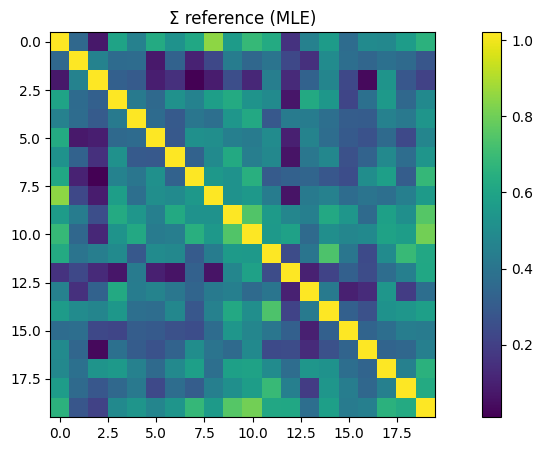

In [32]:
plt.figure(figsize=(12,5))
plt.imshow(np.cov(rin[2,:,:]), cmap='viridis')
plt.colorbar(); plt.title('Σ reference (MLE)')
plt.show()

In [33]:
mean = 0
for i in range(500):
    S = scale=np.eye(N)
    nu_hat = np.trace(np.linalg.solve(rout[0].cov(), S)) / N
    mean += nu_hat/500

In [34]:
mean

np.float64(2.0260558956057757)

## Experience on relation q vs loss on covariance matrix

Compute loss surface of $\Sigma_{true}(N,T)$ vs $\Sigma_{cov}(N,T)$

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import torch

In [52]:
def loss_function_corr(Corr_oos, Corr_pred, T):
    B, N, _ = Corr_oos.shape

    # Matrix difference
    Delta = Corr_pred - Corr_oos  # (B, N, N)

    ## CB: It seems more efficient to compute the Frobenius norm via squaring element-wise and summing.
    # Square of the matrix (Delta^2 = Delta @ Delta) Symetric matrix so we don't need to transpose !
    Delta2 = Delta @ Delta  # (B, N, N)

    # Trace of Delta2 = sum of diagonal
    trace_vals = Delta2.diagonal(dim1=1, dim2=2).sum(dim=1)  # (B,)

    # Normalized Frobenius estimation error (Potters-Bouchaud)
    # loss_cov = torch.sqrt(trace_vals) * T / N**2  # (B,)

    # LW tarket frob loss
    loss_cov = torch.sqrt(trace_vals) / np.sqrt(N)  # (B,)

    return loss_cov.mean()  # scalar

In [53]:
Ns = np.linspace(100, 600, 40, dtype=int)
Ts = np.linspace(20, 70, 20, dtype=int)
loss = []
for N in Ns: 
    for T in Ts:
        df = np.random.randint(5 * N, 10 * N)  # degrees of freedom for invwishart
        Sigma_true = st.invwishart.rvs(df=df, scale=np.eye(N))*(df-N-1)
        Z = np.random.standard_normal((N, T))
        L = np.linalg.cholesky(Sigma_true)
        R = L @ Z
        Sigma_emp = np.cov(R)
        eps = 1e-12
        std = np.sqrt(np.diag(Sigma_emp))
        corr1 = Sigma_emp / (np.outer(std, std) + eps)
        std2 = np.sqrt(np.diag(Sigma_true))
        corr2 = Sigma_true / (np.outer(std2, std2)+ eps)
        loss.append(loss_function_corr(torch.from_numpy(corr1[None,:,:]), torch.from_numpy(corr2[None,:,:]), T))

In [54]:
# meshing
loss_grid = np.array(loss).reshape(len(np.array(Ns)), len(np.array(Ts)))
N_mesh, T_mesh = np.meshgrid(np.array(Ns), np.array(Ts), indexing='ij')

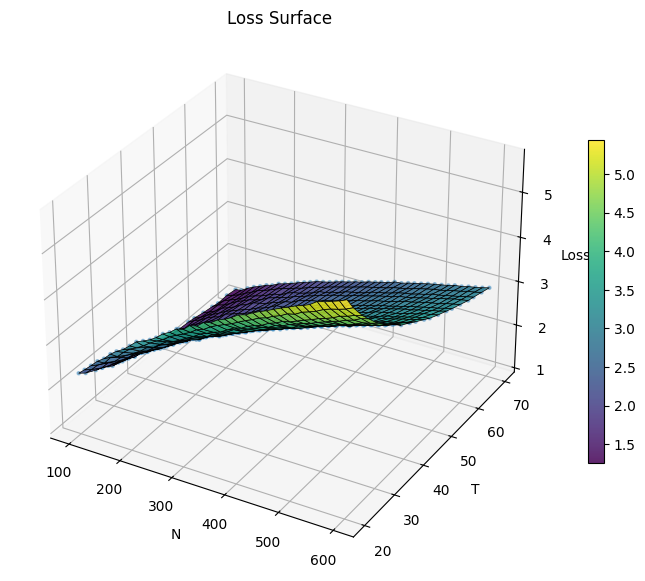

In [55]:
# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')


surf = ax.scatter(
    N_mesh, T_mesh, loss_grid,
    s=5, alpha=0.4, label="data"
)
surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.show()

In [79]:
X = np.column_stack([
    N_mesh.ravel(),
    T_mesh.ravel(),
    loss_grid.ravel()
])
mu = X.mean(axis=0)
sigma = X.std(axis=0)

X_standard = (X - mu)/ sigma

In [80]:
Sig = X_standard.T @ X_standard / X.shape[0]
eigV, U = np.linalg.eigh(Sig)
u3, u2, u1 = U[:, 0], U[:, 1], U[:, 2]

In [81]:
a = np.linspace(-3, 3, 40)
b = np.linspace(-3, 3, 40)
A, B = np.meshgrid(a, b)

In [84]:
Plane_std = (
    + A[..., None] * u1
    + B[..., None] * u2
)

Plane = Plane_std * sigma + mu

N_plane    = Plane[..., 0]
T_plane    = Plane[..., 1]
Loss_plane = Plane[..., 2]

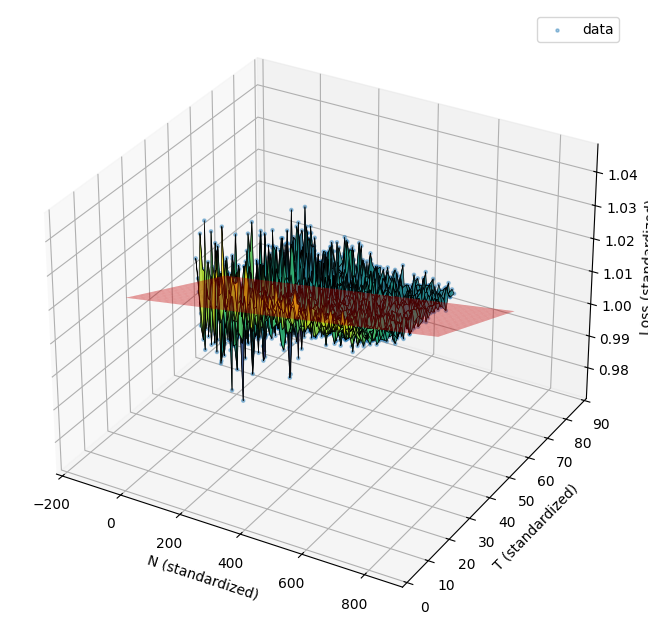

In [102]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

# scatter the data
ax.scatter(
    X[:, 0], X[:, 1], X[:, 2],
    s=5, alpha=0.4, label="data"
)


# plot PCA plane
ax.plot_surface(
    N_plane, T_plane, Loss_plane,
    color="red", alpha=0.4, linewidth=0
)
surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)
ax.set_xlabel("N (standardized)")
ax.set_ylabel("T (standardized)")
ax.set_zlabel("Loss (standardized)")
ax.legend()
plt.show()


2nd experience*

In [104]:
Ns_2 = np.linspace(100, 600, 40, dtype=int)
Ts_2 = np.linspace(20, 70, 20, dtype=int)
loss_2 = []

In [105]:
for N in Ns_2: 
    for T in Ts_2:
        df = np.random.randint(2 * N, 3 * N)  # degrees of freedom for invwishart
        Sigma_true = st.invwishart.rvs(df=df, scale=np.eye(N))*(df-N-1)
        Z = np.random.standard_normal((N, T))
        L = np.linalg.cholesky(Sigma_true)
        R = L @ Z
        Sigma_emp = np.cov(R)
        q = N / T
        loss_2.append((np.linalg.norm(Sigma_true - Sigma_emp, 'fro') / np.sqrt(N)) / np.sqrt(q))


In [106]:
# meshing
loss_grid_2 = np.array(loss_2).reshape(len(np.array(Ns_2)), len(np.array(Ts_2)))
N_mesh_2, T_mesh_2 = np.meshgrid(np.array(Ns_2), np.array(Ts_2), indexing='ij')

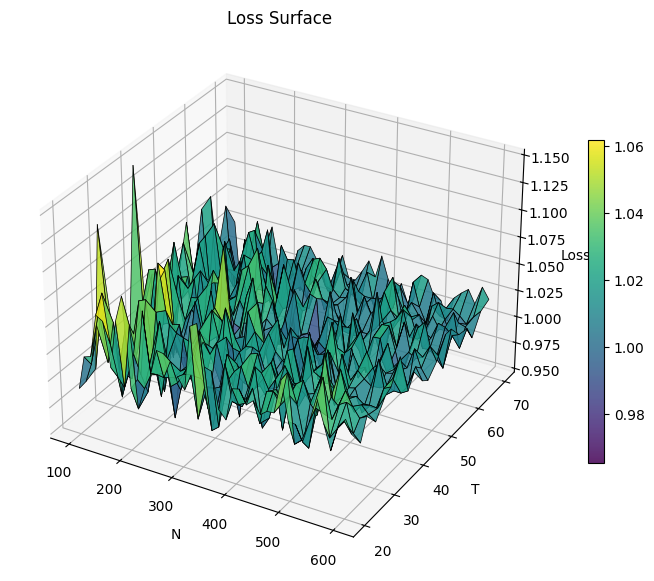

In [107]:
# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh_2, T_mesh_2, loss_grid_2,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.show()

That loss is logic : small N (= small amount of sample) mean big loss, and when T increases (amount of features increases) the loss increases => OK

In [110]:
N_list_test_1 = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180,200,220, 240])
T_list_test_1 = np.array([20, 30, 40, 50, 60, 80, 100, 120, 150, 200, 220])

In [ ]:
len(np.unique(N_list_test_1[:,None]/T_list_test_1[None,:]))

77

In [129]:
(N_list_test_1[:,None]/T_list_test_1[None,:]).size


132

In [ ]:
np.